In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Explanatory Data Analysis

In [5]:
labels = pd.read_csv("drive/My Drive/dog_breed_data/labels.csv")

In [6]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

NOTE: no jpg extenesion in id, we have to add this

In [7]:
# Add .jpg extension ONLY if it's not already present
labels['id'] = labels['id'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')

NOTE: Noticed how the id contains only the image name and no extension(jpg in this scenario)

In [8]:
labels.describe()

id               breed
count                                  10222               10222
unique                                 10222                 120
top     fff43b07992508bc822f33d8ffd902ae.jpg  scottish_deerhound
freq                                       1                 126

In [9]:
labels['breed'].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

NOTE: There exist a difference range of 60 when it comes to the breed counts

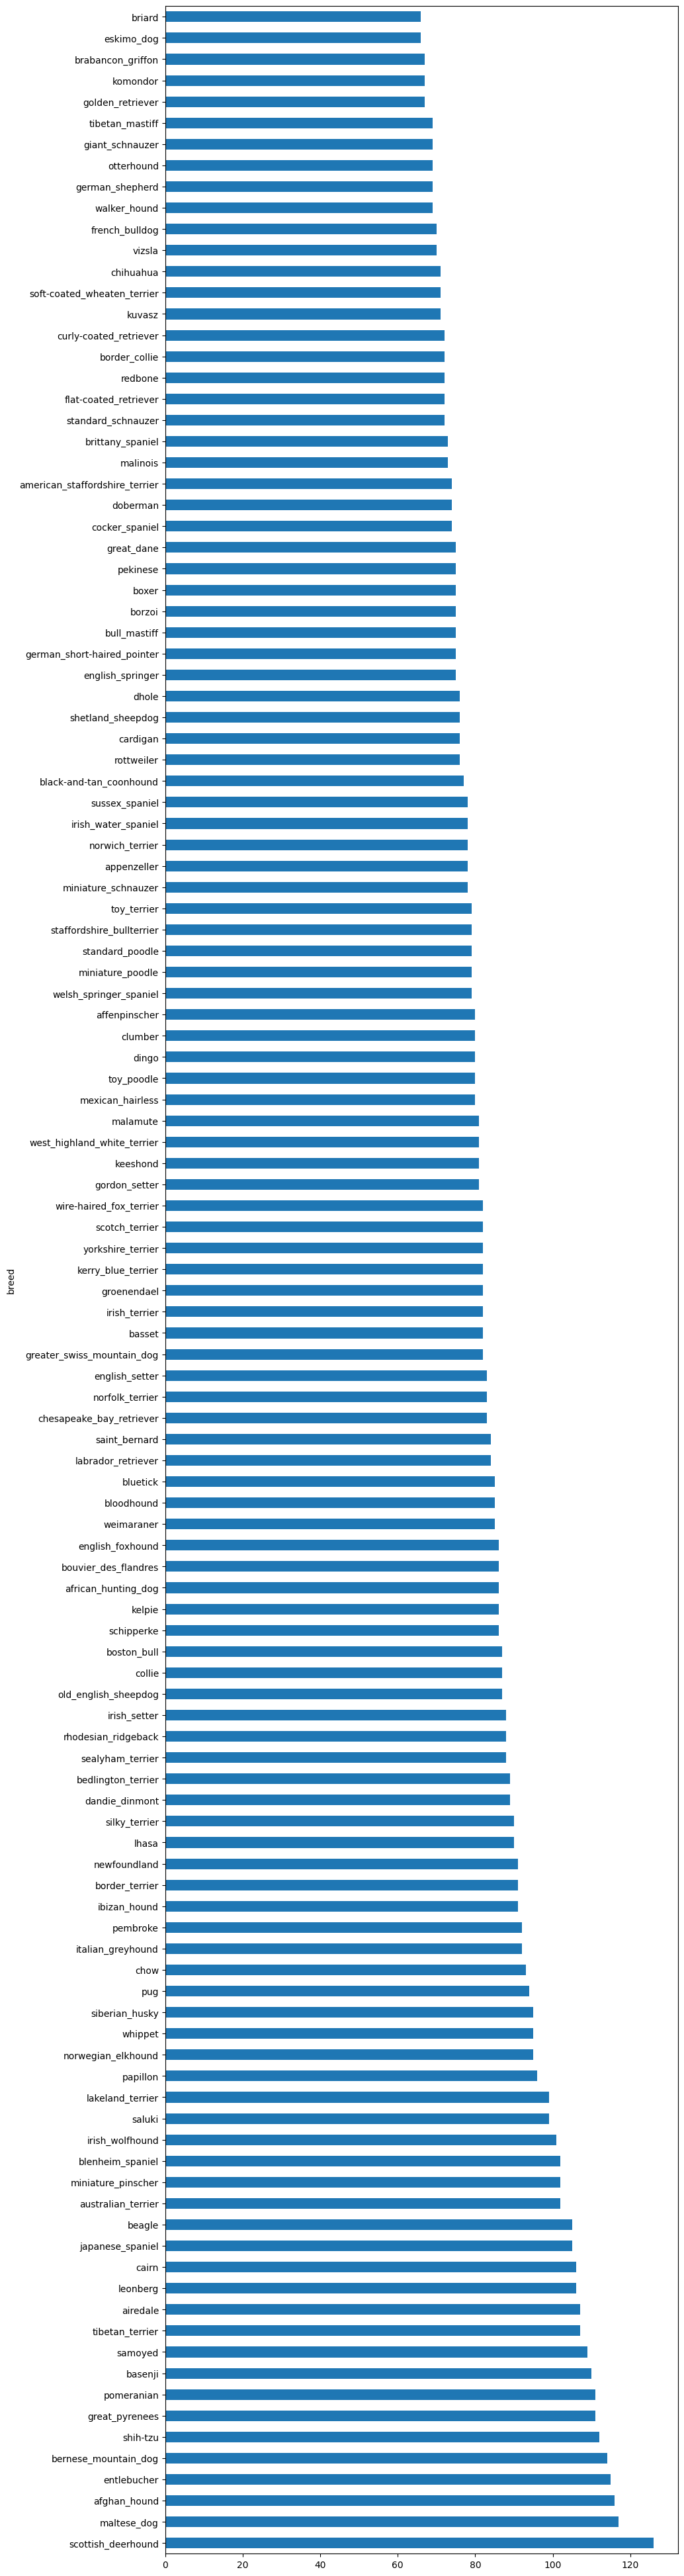

In [10]:
# Check Distribution of breed counts(for inconsistencies)
labels['breed'].value_counts().plot(kind='barh', figsize=(10, 50))
plt.show()

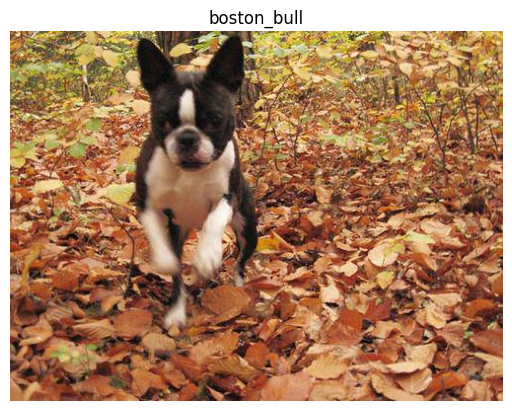

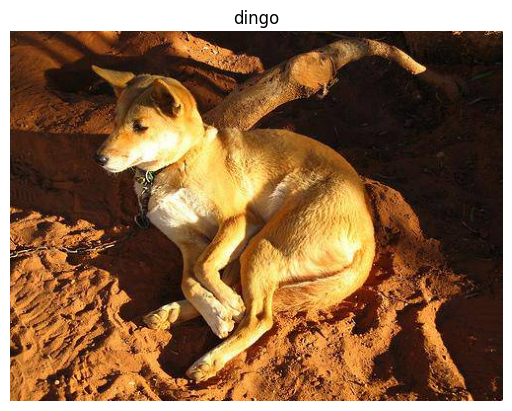

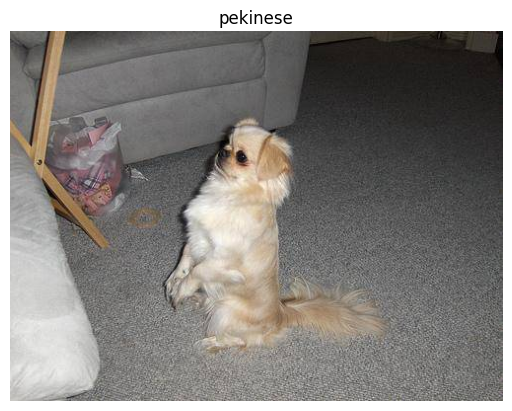

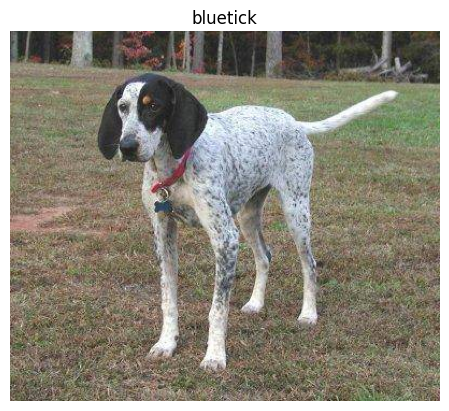

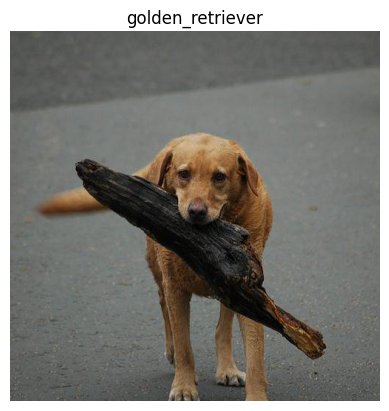

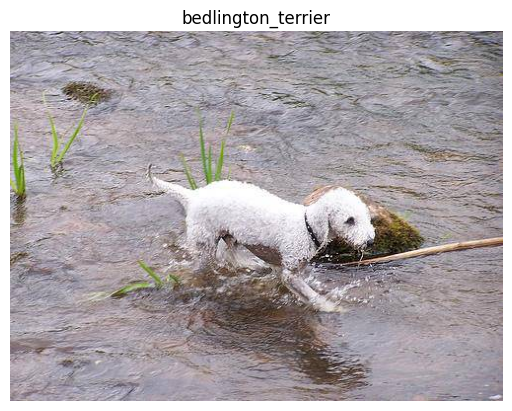

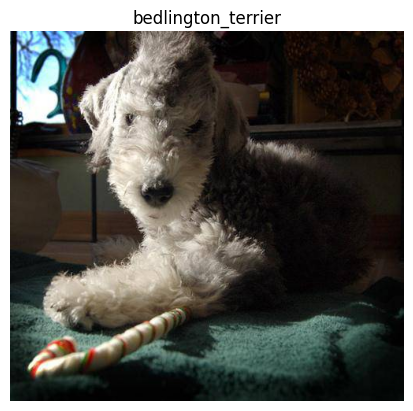

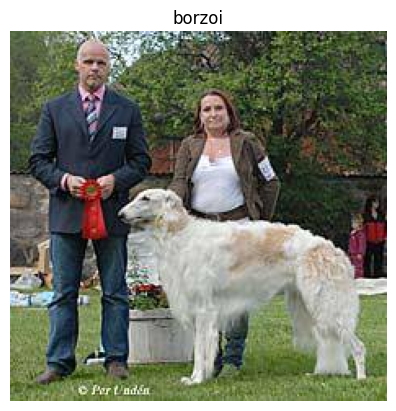

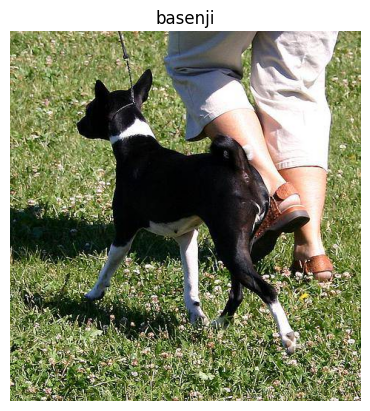

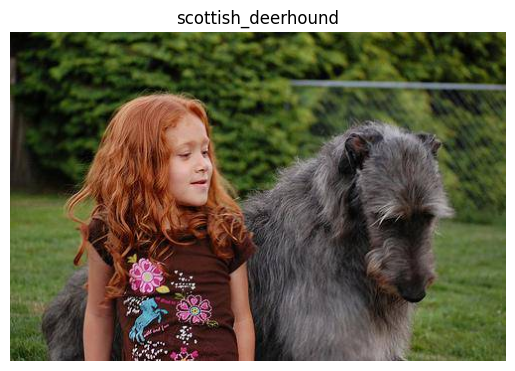

In [11]:
# Visualize first 10 images to identify size mismatch
from PIL import Image
import os
train_dir = 'drive/My Drive/dog_breed_data/train/'
for i in range(10):
    sample_image_id = labels.iloc[i]['id']
    img_path = os.path.join(train_dir, sample_image_id)
    img = Image.open(img_path)
    plt.figure()  # Create a new figure for each image(to find mismatch in sizes)
    plt.imshow(img)
    plt.title(labels.iloc[i]['breed'])
    plt.axis('off')
plt.show()

We can see that images contain different shapes

In [12]:
# Collect (filename, (width, height)) for every image
sizes = []
for fname in os.listdir(train_dir):
    if not fname.lower().endswith('.jpg'):
        continue
    path = os.path.join(train_dir, fname)
    with Image.open(path) as img:
        sizes.append((fname, img.size))  # img.size == (width, height)

# Find the image with the smallest area
smallest = min(sizes, key=lambda x: x[1][0] * x[1][1])
fname, (w, h) = smallest
print(f"Smallest image is {fname} with size {w}×{h} (area={w*h})")

Smallest image is b44ddd50615e6526250b84754798c47d.jpg with size 120×102 (area=12240)


# Data Preprocess & Augmentation

In [13]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [15]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create separate generators for training and validation
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    validation_split=0.2  # 20% Validation Split
)

# Generate the training data
train_gen = train_datagen.flow_from_dataframe(
    labels,
    directory=train_dir,
    x_col='id', y_col='breed',
    subset='training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generate the validation data
val_gen = train_datagen.flow_from_dataframe(
    labels,
    directory=train_dir,
    x_col='id', y_col='breed',
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


Class Weight Calculation(Compensation for imbalances)

Point is to have more penalty for classes with lower frequencies during training

In [16]:
# Compensation for breed class imbalances
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# extract the training labels array
y_train = train_gen.classes
class_indices = train_gen.class_indices # integer‑encode class labels

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_indices)),
    y=y_train
)
class_weight = dict(enumerate(weights))

# Using model MobileNetV2 for Transfer Learning

In [17]:
# MobileNetV2 imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers    import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models    import Model
from tensorflow.keras.optimizers import Adam

In [18]:
# --- constants ---
num_classes = 120

# 1. instantiate the backbone
base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False   # freeze all layers(inital training strategy)

# 2. build the head
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)         # keep batchnorm in inference mode
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# 3. compile
model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,975,416 (11.35 MB)

 Trainable params: 717,432 (2.74 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
# Set callbacks for early stopping and learning rate reduction
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [21]:
# Initial training (Freezed PreTrained Model)
EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.0511 - loss: 4.6709 - val_accuracy: 0.5059 - val_loss: 2.9314 - learning_rate: 1.0000e-04
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.3682 - loss: 2.8063 - val_accuracy: 0.6595 - val_loss: 1.5971 - learning_rate: 1.0000e-04
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.5531 - loss: 1.7956 - val_accuracy: 0.7153 - val_loss: 1.2023 - learning_rate: 1.0000e-04
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.6088 - loss: 1.4822 - val_accuracy: 0.7153 - val_loss: 1.0957 - learning_rate: 1.0000e-04
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.6578 - loss: 1.2520 - val_accuracy: 0.7197 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.6694 - loss: 1.1835 - val_accuracy: 0.7348 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - acc

# Model Evaluation

In [22]:
evaluation = model.evaluate(val_gen)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7587 - loss: 0.8098
Validation Loss: 0.8191
Validation Accuracy: 0.7578


In [23]:
# Generate classification report (precision, f1 score)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Reset the generator to ensure we go through all validation samples
val_gen.reset()

# Get true labels
y_true = val_gen.classes

# Predict on validation data
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert class indices back to breed names for readability
class_indices = val_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Generate classification report
target_names = [inv_class_indices[i] for i in range(len(class_indices))]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

64/64 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step

Classification Report:
                                precision    recall  f1-score   support

                 affenpinscher       0.71      0.79      0.75        19
                  afghan_hound       0.89      0.81      0.85        21
           african_hunting_dog       0.92      0.92      0.92        13
                      airedale       0.64      0.78      0.71        23
american_staffordshire_terrier       0.56      0.77      0.65        13
                   appenzeller       0.78      0.39      0.52        18
            australian_terrier       0.80      0.57      0.67        21
                       basenji       0.91      0.77      0.83        26
                        basset       0.81      0.72      0.76        18
                        beagle       0.72      0.76      0.74        17
            bedlington_terrier       0.92      0.85      0.88        27
          bernese_mountain_dog       0.92      0.88      0.90        26

Saving Model

In [25]:
model.save("drive/My Drive/dog_breed_data/Paw Detector.keras")

In [27]:
from tensorflow.keras.models import load_model
model = load_model("drive/My Drive/dog_breed_data/Paw Detector.keras")

# Fine Tuning

In [32]:
## Step 1: Unfreeze the Base Model Layers (Selective Fine-Tuning)
base_model = model.layers[1]  # The Input layer is layers[0], base model is layers[1]
# Keep the first 100 layers frozen and unfreeze the rest
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,282 (16.82 MB)

 Trainable params: 2,578,872 (9.84 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 1,434,866 (5.47 MB)

In [33]:
## Step 2: Recompile with a Lower Learning Rate
fine_tuning_lr = 0.00001  # 10x smaller than the initial training rate
optimizer = Adam(learning_rate=fine_tuning_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
## Step 3: Set Up Callbacks for Fine-Tuning
from tensorflow.keras.callbacks import ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Learning rate reduction if performance plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
# Save best model during fine-tuning
checkpoint = ModelCheckpoint('paw_detector_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks = [early_stop, reduce_lr, checkpoint]

In [35]:
## Step 4: Fine-Tune the Model
fine_tuning_epochs = 10
# train with existing data generators
history_fine_tuning = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tuning_epochs,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6118 - loss: 1.3903
Epoch 1: val_accuracy improved from -inf to 0.74804, saving model to paw_detector_finetuned.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 0.6119 - loss: 1.3898 - val_accuracy: 0.7480 - val_loss: 0.8176 - learning_rate: 1.0000e-05
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6871 - loss: 1.0925
Epoch 2: val_accuracy did not improve from 0.74804
256/256 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.6872 - loss: 1.0924 - val_accuracy: 0.7383 - val_loss: 0.8257 - learning_rate: 1.0000e-05
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7097 - loss: 1.0004
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_accuracy did not improve from 0.74804
256/256 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.7097 - loss: 1.0004 - val_accuracy: 0.7383 - val_loss: 0.8442 - learning_rate: 1.0000e-05
Epoch 4/10
256/256 ━━━━━━━━━━━

Evaluate Fine-Tuned Model

In [36]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Final validation accuracy after fine-tuning: {val_acc:.4f}")
print(f"Final validation loss after fine-tuning: {val_loss:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7473 - loss: 0.7912
Final validation accuracy after fine-tuning: 0.7432
Final validation loss after fine-tuning: 0.8334


In [37]:
# Reset the generator
val_gen.reset()

# Predict on validation data
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

class_indices = val_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
target_names = [inv_class_indices[i] for i in range(len(class_indices))]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step

Classification Report:
                                precision    recall  f1-score   support

                 affenpinscher       0.81      0.89      0.85        19
                  afghan_hound       0.88      0.71      0.79        21
           african_hunting_dog       0.80      0.92      0.86        13
                      airedale       0.71      0.74      0.72        23
american_staffordshire_terrier       0.50      0.77      0.61        13
                   appenzeller       0.77      0.56      0.65        18
            australian_terrier       0.63      0.57      0.60        21
                       basenji       0.94      0.65      0.77        26
                        basset       0.68      0.83      0.75        18
                        beagle       0.76      0.76      0.76        17
            bedlington_terrier       1.00      0.89      0.94        27
          bernese_mountain_dog       0.92      0.85      0.88        26

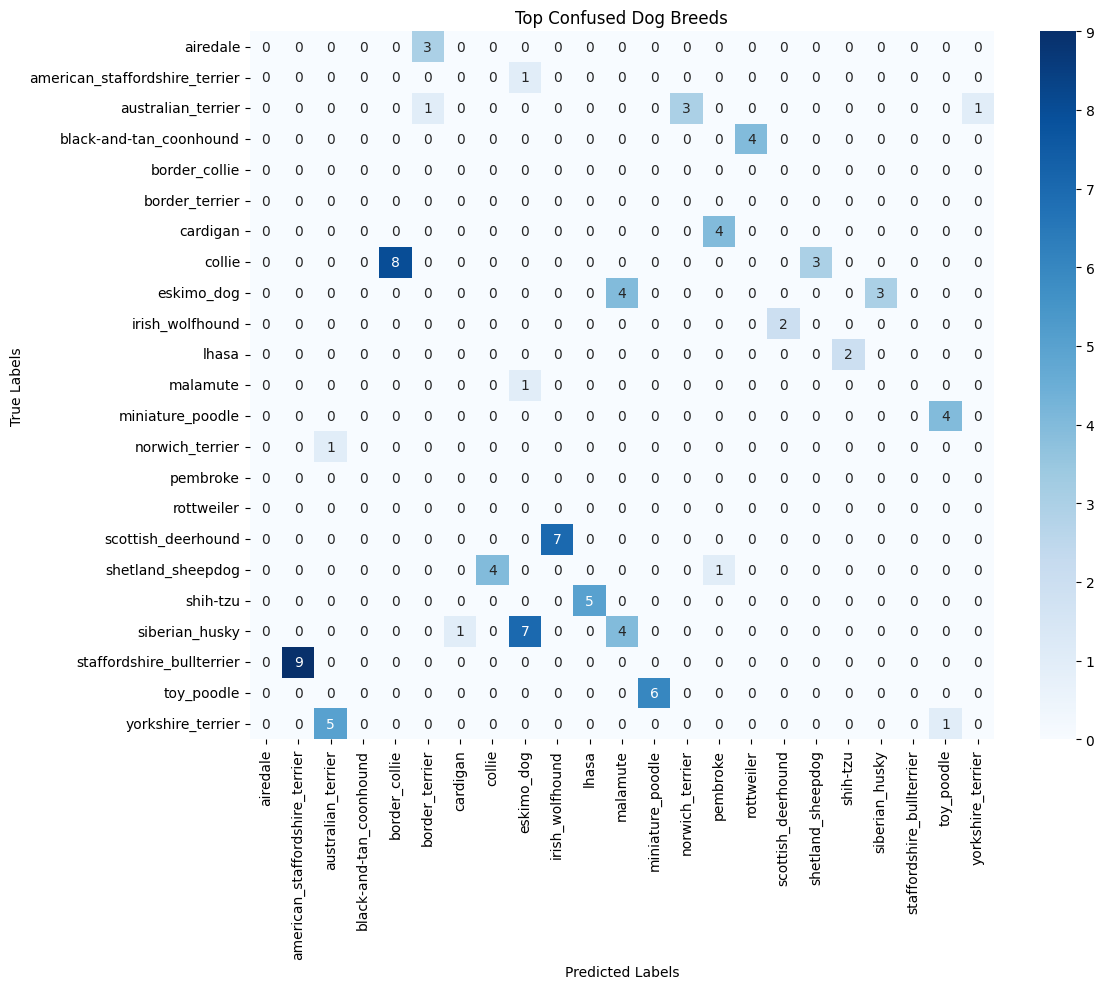

In [43]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a mask for the diagonal (correctly classified instances)
np.fill_diagonal(cm, 0)

# Find the top confused pairs
n_top_confused = 15  # Number of top confused pairs to show
top_confused = []

# Iterate through the confusion matrix to find the top confused pairs
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # Skip the diagonal
            top_confused.append((i, j, cm[i, j]))

# Sort by confusion count (descending)
top_confused.sort(key=lambda x: x[2], reverse=True)

# Take only the top N confused pairs
top_confused = top_confused[:n_top_confused]

# Create a smaller confusion matrix with just these breeds
breeds_to_include = set()
for i, j, _ in top_confused:
    breeds_to_include.add(i)
    breeds_to_include.add(j)

breeds_to_include = sorted(list(breeds_to_include))
focused_cm = cm[np.ix_(breeds_to_include, breeds_to_include)]

# Get breed names for these indices
breed_names = [inv_class_indices[i] for i in breeds_to_include]

# Plot the focused confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(focused_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Top Confused Dog Breeds')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NOTE: We can see our there is a trend in confusion since small variated breeds are shown to be most confused

##Visualize Training Progress

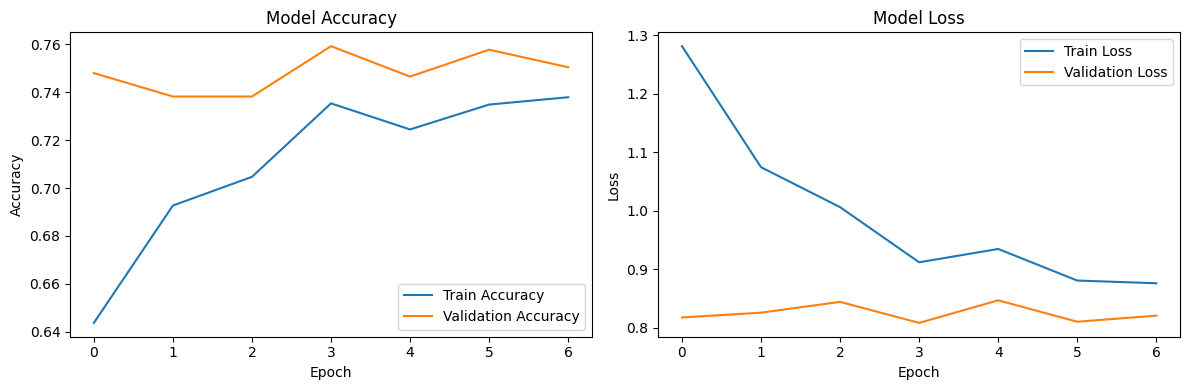

In [39]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the fine-tuning progress
plot_history(history_fine_tuning)

In [40]:
# Save the final model
model.save("Paw Detector Final Model.keras")
print("Final model saved successfully!")

Final model saved successfully!


# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


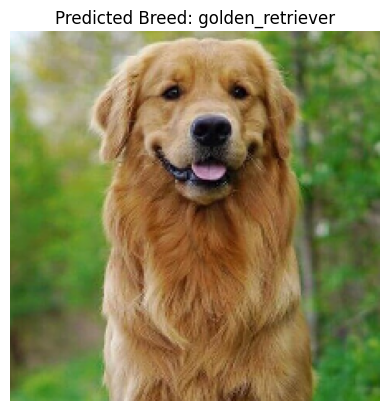

In [42]:
from tensorflow.keras.preprocessing import image
img_path = 'drive/My Drive/dog_breed_data/golden-retriever-dog-breed-info.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
prediction = model.predict(img_array)

predicted_class = np.argmax(prediction, axis=1)[0]
inv_class_indices = {v: k for k, v in train_gen.class_indices.items()}
predicted_label = inv_class_indices[predicted_class]

# Display the image
plt.imshow(img)
plt.title(f"Predicted Breed: {predicted_label}")
plt.axis('off')
plt.show()

NOTE: The final accuracy of the model by testing the validation set was about approximately 0.75

This is considered acceptable since most research results show such domain applications contain accuracy ranging from (0.70 to 0.85)